In [9]:
import numpy as np
import pandas as pd
import random, tqdm
import matplotlib.pyplot as plt
import torch

**Image loading and resizing**

We have choosen 256x256

In [10]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Path to the directory contains images
images_dir = "data/data/images"

# List all image filenames in the directory
image_filenames = os.listdir(images_dir)

# Create an empty list to store the images
images = []

# Load images as NumPy arrays and store them in the list
for filename in tqdm(image_filenames):
    image_path = os.path.join(images_dir, filename)
    if os.path.isfile(image_path):  # Check if it's a file, not a directory (to avoid the notebook checkpoints)
        image = Image.open(image_path)

        # Resize images
        target_size = (256, 256)
        image = image.resize(target_size, Image.LANCZOS)
        
        # Convert image to array
        image_array = np.array(image)
        images.append(image_array)

# Convert the list of arrays to a single NumPy array
images = np.array(images)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.58it/s]


In [17]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Path to the directory containing masks in your Google Drive
masks_dir = "data/data/masks"

# List all mask filenames in the directory
mask_filenames = os.listdir(masks_dir)

# Create an empty list to store the masks
masks = []

# Load masks as NumPy arrays and store them in the list
for filename in tqdm(mask_filenames):
    mask_path = os.path.join(masks_dir, filename)
    if os.path.isfile(mask_path):  # Check if it's a file, not a directory (to avoid the notebook checkpoints)
        mask = Image.open(mask_path)
    
        # Resize masks to the same size as images
        target_size = (256, 256)
        mask = mask.resize(target_size, Image.LANCZOS)
    
        # Convert mask to array
        mask_array = np.array(mask)
    
        masks.append(mask_array)

# Convert the list of arrays to a single NumPy array
masks = np.array(masks)
masks = masks[..., 0] # correct an error
masks = masks[..., np.newaxis]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.14it/s]


In [18]:
masks.shape

(1000, 256, 256, 1)

In [19]:
np.save("data/data/images.npy", images)
np.save("data/data/masks.npy", masks)

**Train - Val/Test Splitting**

In [20]:
images = np.load("data/data/images.npy")
masks = np.load("data/data/masks.npy")

In [21]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42)

# Print the shapes of the train and test sets
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train masks shape:", train_masks.shape)
print("Test masks shape:", test_masks.shape)

Train images shape: (700, 256, 256, 3)
Test images shape: (300, 256, 256, 3)
Train masks shape: (700, 256, 256, 1)
Test masks shape: (300, 256, 256, 1)


In [22]:
np.save("data/data/train_nonaugmented/train_images.npy", train_images)
np.save("data/data/train_nonaugmented/train_masks.npy", train_masks)
np.save("data/data/test/test_images.npy", test_images)
np.save("data/data/test/test_masks.npy", test_masks)

**Data augmentation**

In [23]:
import numpy as np
from tqdm import tqdm
import albumentations as A

# Define Albumentations transformations
transformations = A.Compose(
    [
        A.OneOrOther(
            A.Compose([
                A.RandomRotate90(),
                A.OneOf([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
                ], p=1)
            ]),
            A.Compose([
                A.Rotate(p=0.5),
                A.OneOf([
                    A.HueSaturationValue(p=0.5),
                    A.RGBShift(p=0.7)
                ], p=1)
            ])
        ),
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=0.5)
    ]
)

# Create lists for storing the augmented images and masks
augmented_images = []
augmented_masks = []

# Number of times to apply augmentation for each image
num_augmentations = 4

# Assuming train_images and train_masks are preloaded numpy arrays
# Apply transformations
for image, mask in tqdm(zip(train_images, train_masks), total=train_images.shape[0]):
    for _ in range(num_augmentations):
        # Apply Albumentations transformations
        augmented = transformations(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])

# Convert the lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented images
combined_images = np.concatenate([train_images, augmented_images], axis=0)
combined_masks = np.concatenate([train_masks, augmented_masks], axis=0)

# Save them in the data folder
np.save("data/data/train_augmented/combined_images.npy", combined_images)
np.save("data/data/train_augmented/combined_masks.npy", combined_masks)

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:02<00:00, 255.01it/s]


In [24]:
print("number of total images", len(combined_images))
print("number of total masks",len(combined_masks))

number of total images 3500
number of total masks 3500


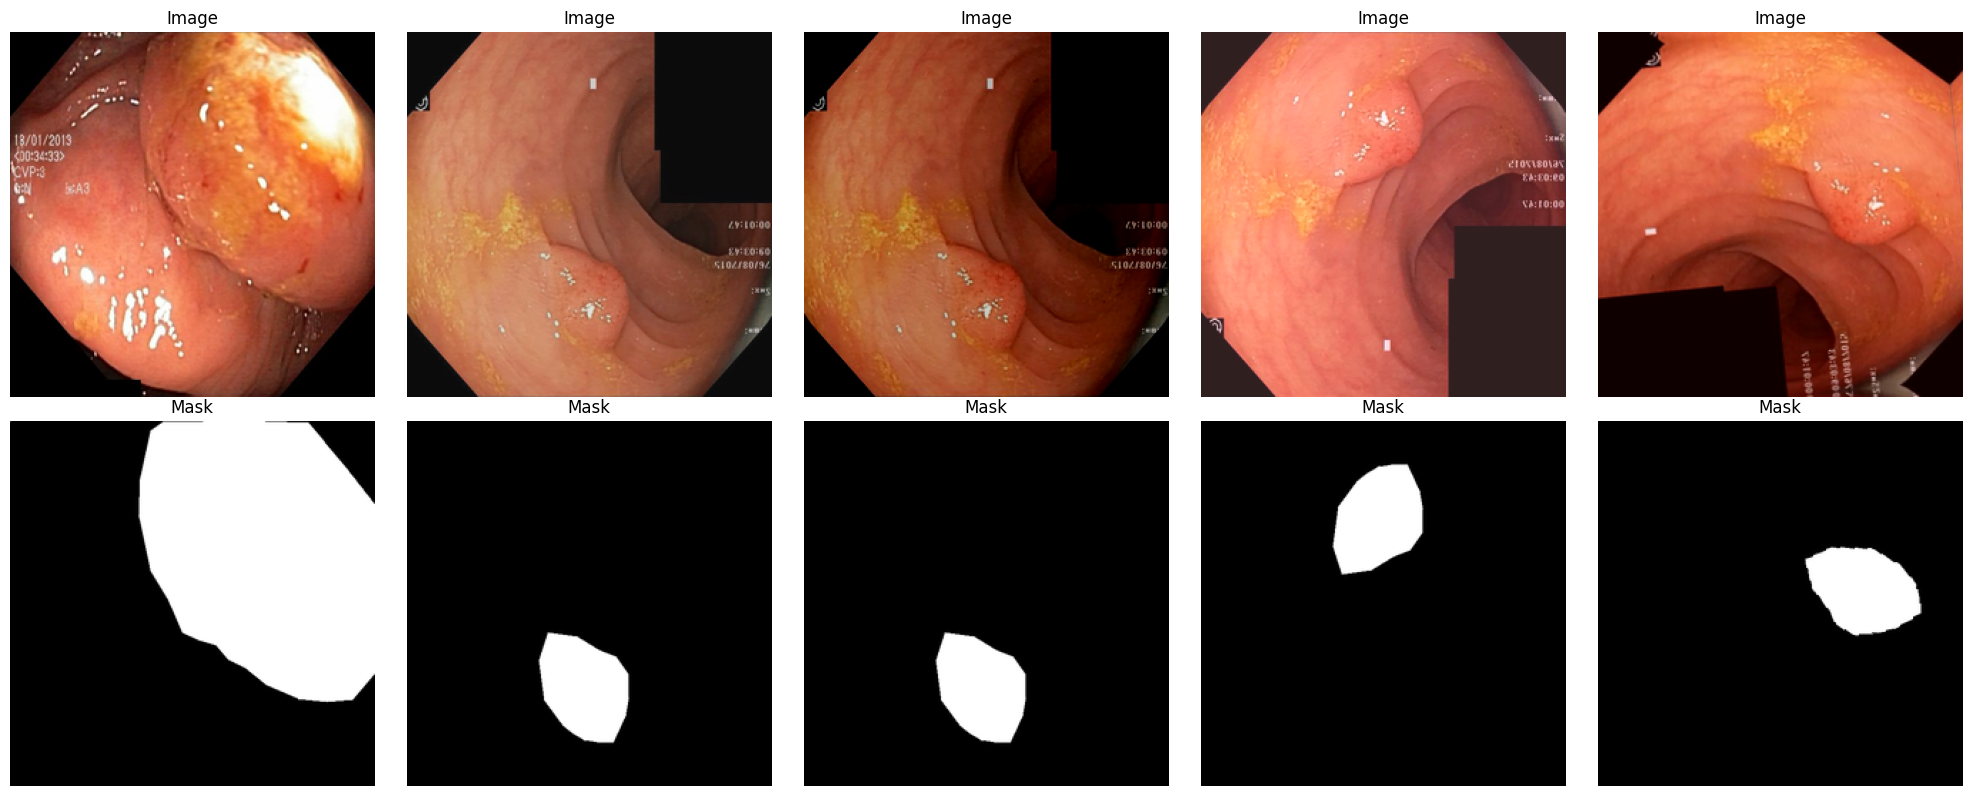

In [25]:
import matplotlib.pyplot as plt
import random

# Select 5 random indices
#random_indices = random.sample(range(len(combined_images)), 5)
random_indices = [0,1000,1001,1002, 1003]
# Create a subplot with a grid view to display images and masks
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot the 5 random images with their corresponding masks
for i, idx in enumerate(random_indices):
    # Plot the image
    axes[0, i].imshow(combined_images[idx])
    axes[0, i].set_title("Image")
    axes[0, i].axis('off')

    # Plot the mask
    axes[1, i].imshow(combined_masks[idx], cmap='gray')  # No need to specify cmap for grayscale masks
    axes[1, i].set_title("Mask")
    axes[1, i].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
